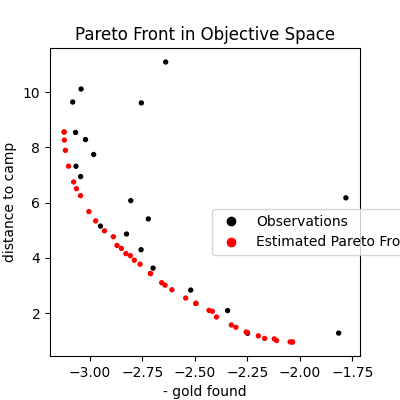

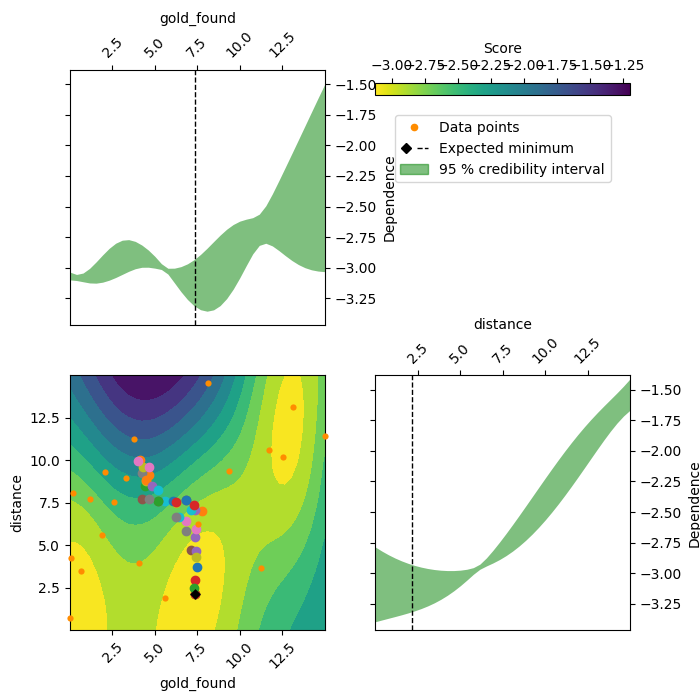

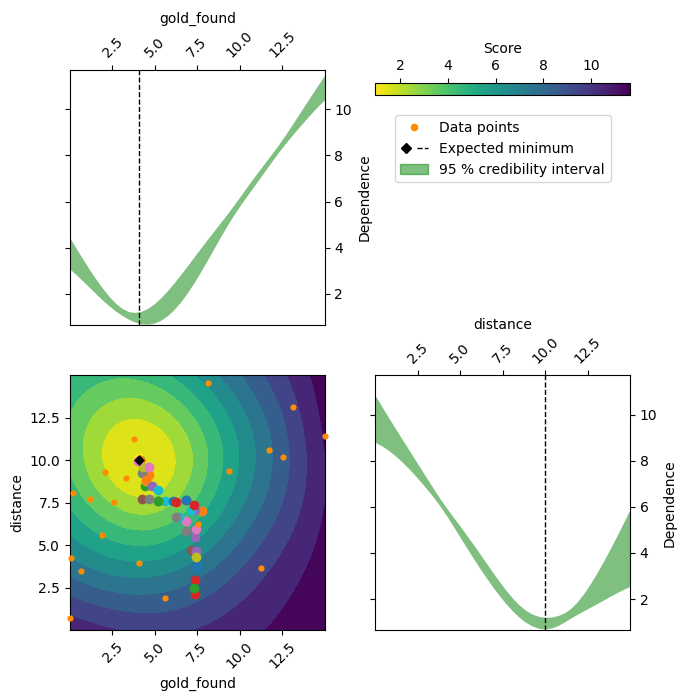

In [ ]:
import ProcessOptimizer as po
from ProcessOptimizer.model_systems import get_model_system
from ProcessOptimizer import Optimizer

# Define the model system
gold_model_system = get_model_system("gold_map")
distance_model_system = get_model_system("distance_map")

space = distance_model_system.space

opt = Optimizer(space, n_initial_points=4, n_objectives=2)

for i in range(20):
    new_dig_site = opt.ask()
    gold_found = gold_model_system.get_score(new_dig_site)
    distance = distance_model_system.get_score(new_dig_site)
    result = opt.tell(new_dig_site, [gold_found, distance])

front = po.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"], return_data=True)
figure_list = []
for n in range(len(result)):
    figure_list.append(po.plot_objective(
        result = result[n],
        pars = "expected_minimum",
        dimensions= ["gold_found", "distance"],
    ))
    for point in front[2]:
        figure_list[n][1][0].scatter(x=[point[0]], y=[point[1]], c="red")


In [23]:
len(front[2])

40

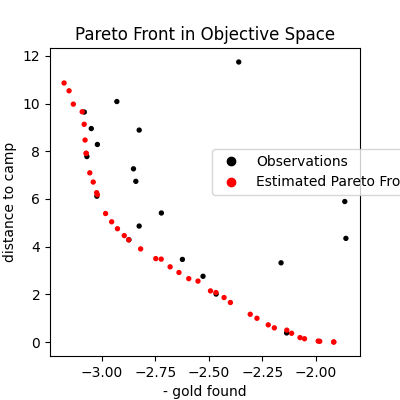

In [11]:
#ipympl is needed for the following cell to render. without ipympl, the user is still able to run po.plot_pareto(optimizer) but the plot will not be interactive.
%matplotlib widget
po.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"])